# Task 1

---

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [5]:
import requests
from bs4 import BeautifulSoup

import pandas as pd
import nltk
import numpy as np


nltk.download('stopwords')
nltk.download('punkt')  # For tokenization
nltk.download('wordnet')  #for lemitization

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [9]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | British Airways is absolute ...
1,✅ Trip Verified | The flight time was changed ...
2,✅ Trip Verified | I'm so fraustrated. My fli...
3,✅ Trip Verified | We have sat on this plane fo...
4,Not Verified | British Airways stranding my w...


In [11]:
df.to_csv("BA_reviews.csv")

Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

In [14]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('BA_reviews.csv')

# Clean the data by removing "✅ Trip Verified" and "Not Verified" (or any other unnecessary text)
df['reviews'] = df['reviews'].str.replace(r"✅ Trip Verified|Not Verified", "", regex=True).str.strip()

# Save the cleaned data to a new CSV file
df.to_csv('BA_reviews2.csv', index=False)


In [16]:
# removing extra punctuations
df['reviews'] = df['reviews'].str.replace(r'[^\w\s]', '', regex=True)

#ensuring consistency we will convert all text to lowercase
df['reviews'] = df['reviews'].str.lower()

# removing stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

def remove_stop_words(text):
    word_tokens = word_tokenize(text)
    return ' '.join([word for word in word_tokens if word not in stop_words])

df['reviews'] = df['reviews'].apply(remove_stop_words)

# enrusing spellings are correct
# from spellchecker import SpellChecker

# spell = SpellChecker()

# def correct_spelling(text):
#     words = text.split()
#     corrected_words = [spell.correction(word) if spell.correction(word) is not None else word for word in words]
#     return ' '.join(corrected_words)

# df['reviews'] = df['reviews'].apply(correct_spelling)




In [42]:
# removing duplicates
df = df.drop_duplicates(subset=['reviews'])

# handle missing values in the data
df = df.dropna(subset=['reviews'])

# extracting keywords to help focus on relevant topics using NLP techniques
from textblob import TextBlob

def extract_entities_with_textblob(text):
    blob = TextBlob(text)
    return [word for word, tag in blob.tags if tag in ['NNP', 'NNPS']]

df['entities'] = df['reviews'].apply(extract_entities_with_textblob)





In [90]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from textblob import Word

# Initialize VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Sentiment analysis function using VADER
def analyze_sentiment_vader(text):
    sentiment_score = analyzer.polarity_scores(text)
    # Determine sentiment based on the compound score
    if sentiment_score['compound'] >= 0.05:
        return 'positive'
    elif sentiment_score['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment analysis using VADER
df['sentiment'] = df['reviews'].apply(analyze_sentiment_vader)

# Tokenization and lemmatization function
def lemmatize_text(text):
    # Tokenize text and lemmatize each word
    blob = TextBlob(text)
    lemmatized_text = ' '.join([Word(word).lemmatize() for word in blob.words])
    return lemmatized_text

# Apply lemmatization before sentiment analysis
df['reviews'] = df['reviews'].apply(lemmatize_text)


In [92]:

# analysing each topic separately for actionable insights
from gensim import corpora
from gensim.models import LdaModel

# Tokenize reviews
reviews_tokenized = [text.split() for text in df['reviews']]

# Create a dictionary and corpus
dictionary = corpora.Dictionary(reviews_tokenized)
corpus = [dictionary.doc2bow(review) for review in reviews_tokenized]

# Train the LDA model
lda = LdaModel(corpus, num_topics=5, id2word=dictionary)

# Print top topics
topics = lda.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.028*"flight" + 0.017*"ba" + 0.010*"hour" + 0.010*"service" + 0.009*"time"')
(1, '0.026*"flight" + 0.015*"ba" + 0.008*"service" + 0.008*"crew" + 0.007*"hour"')
(2, '0.016*"seat" + 0.012*"flight" + 0.010*"ba" + 0.008*"service" + 0.007*"business"')
(3, '0.025*"flight" + 0.017*"ba" + 0.010*"service" + 0.009*"time" + 0.008*"seat"')
(4, '0.032*"flight" + 0.016*"ba" + 0.011*"seat" + 0.008*"service" + 0.007*"time"')


In [94]:
# Add a column for review length
df['review_length'] = df['reviews'].apply(len)


In [98]:
df.to_csv('BA_reviews4.csv', index=False)


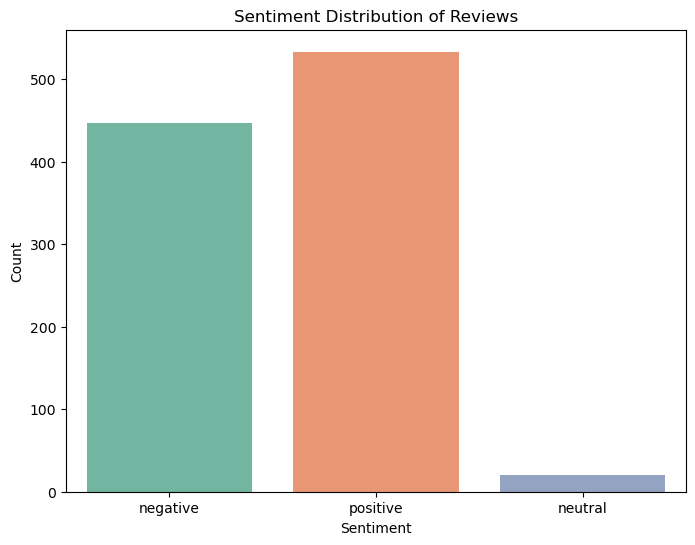

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sentiment Distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='sentiment', palette='Set2')
plt.title('Sentiment Distribution of Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


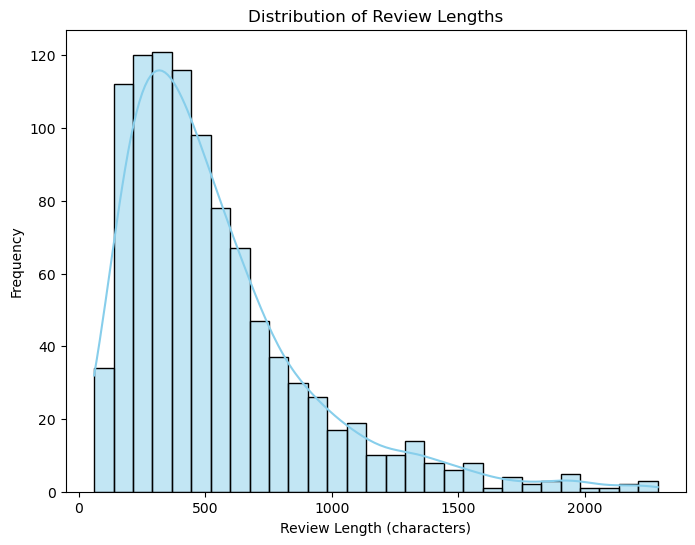

In [102]:
# Review Length Distribution
plt.figure(figsize=(8, 6))
sns.histplot(df['review_length'], kde=True, color='skyblue')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (characters)')
plt.ylabel('Frequency')
plt.show()


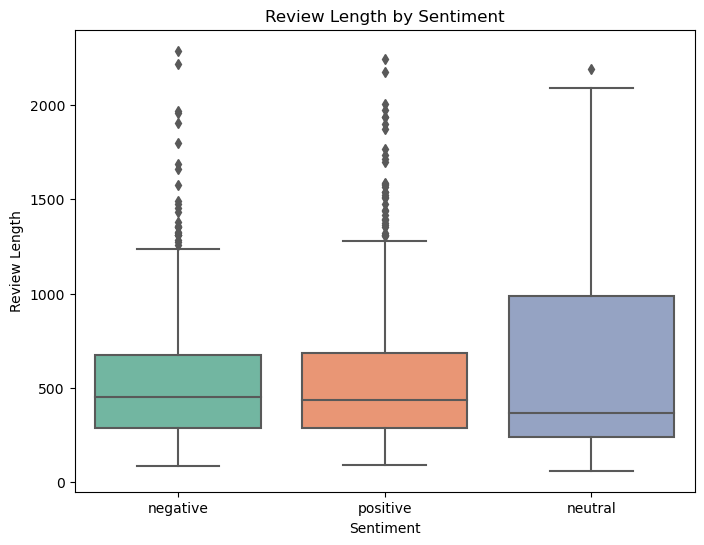

In [104]:
# Boxplot for Sentiment vs. Review Length
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='sentiment', y='review_length', palette='Set2')
plt.title('Review Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Review Length')
plt.show()


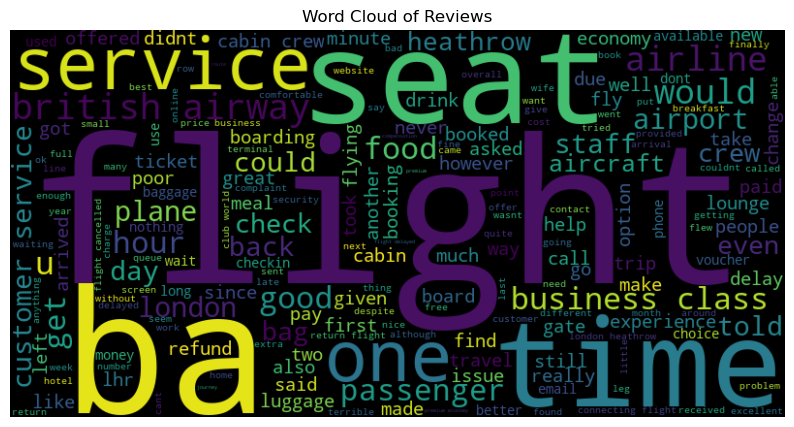

In [106]:
from wordcloud import WordCloud

# Combine all reviews into one text
all_reviews = ' '.join(df['reviews'])

# Generate the word cloud
wordcloud = WordCloud(stopwords=stop_words, width=800, height=400, colormap='viridis').generate(all_reviews)

# Display the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Reviews')
plt.show()


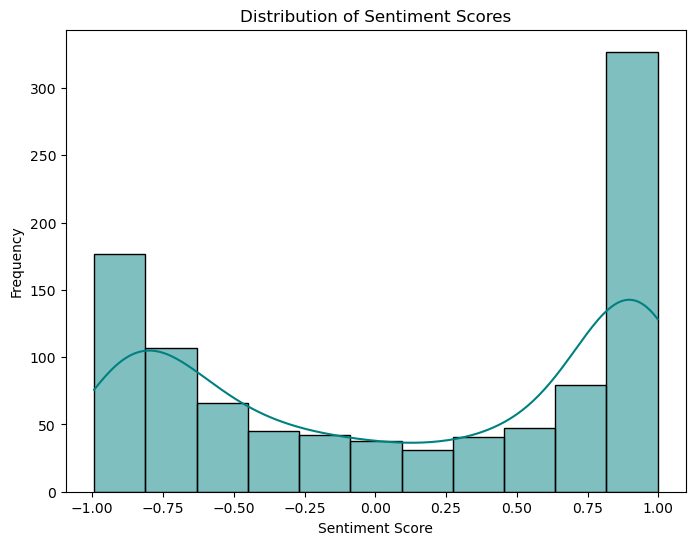

In [108]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

# Calculate sentiment scores
df['sentiment_score'] = df['reviews'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Plot sentiment scores
plt.figure(figsize=(8, 6))
sns.histplot(df['sentiment_score'], kde=True, color='teal')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()


In [88]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from textblob import Word

# Initialize VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Sentiment analysis function using VADER
def analyze_sentiment_vader(text):
    sentiment_score = analyzer.polarity_scores(text)
    # Determine sentiment based on the compound score
    if sentiment_score['compound'] >= 0.05:
        return 'positive'
    elif sentiment_score['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment analysis using VADER
df['sentiment'] = df['reviews'].apply(analyze_sentiment_vader)

# Tokenization and lemmatization function
def lemmatize_text(text):
    # Tokenize text and lemmatize each word
    blob = TextBlob(text)
    lemmatized_text = ' '.join([Word(word).lemmatize() for word in blob.words])
    return lemmatized_text

# Apply lemmatization before sentiment analysis
df['reviews'] = df['reviews'].apply(lemmatize_text)
